# Web scraper

Reference: 
- [YouTube: Add Any Docs to Replit's AI Chat](https://www.youtube.com/watch?v=VLT08ugfpvA&t=2s)
- [Replit: docs2md](https://replit.com/@matt/docs2md?v=1&utm_source=matt&utm_medium=youtube&utm_campaign=tutorials)

In [ ]:
import logging
import os
import time
from urllib.parse import urlparse

import treq
from scrapy.crawler import CrawlerProcess
from scrapy.linkextractors import LinkExtractor
from scrapy.spiders import CrawlSpider, Rule
from slugify import slugify
logger = logging.getLogger(__name__)

Indicate the doc web, need to have https://docs.. format

In [ ]:
DOCS_URL = "https://docs.fastht.ml"

Get JINA api token from https://jina.ai/

Scroll down the page, copy API

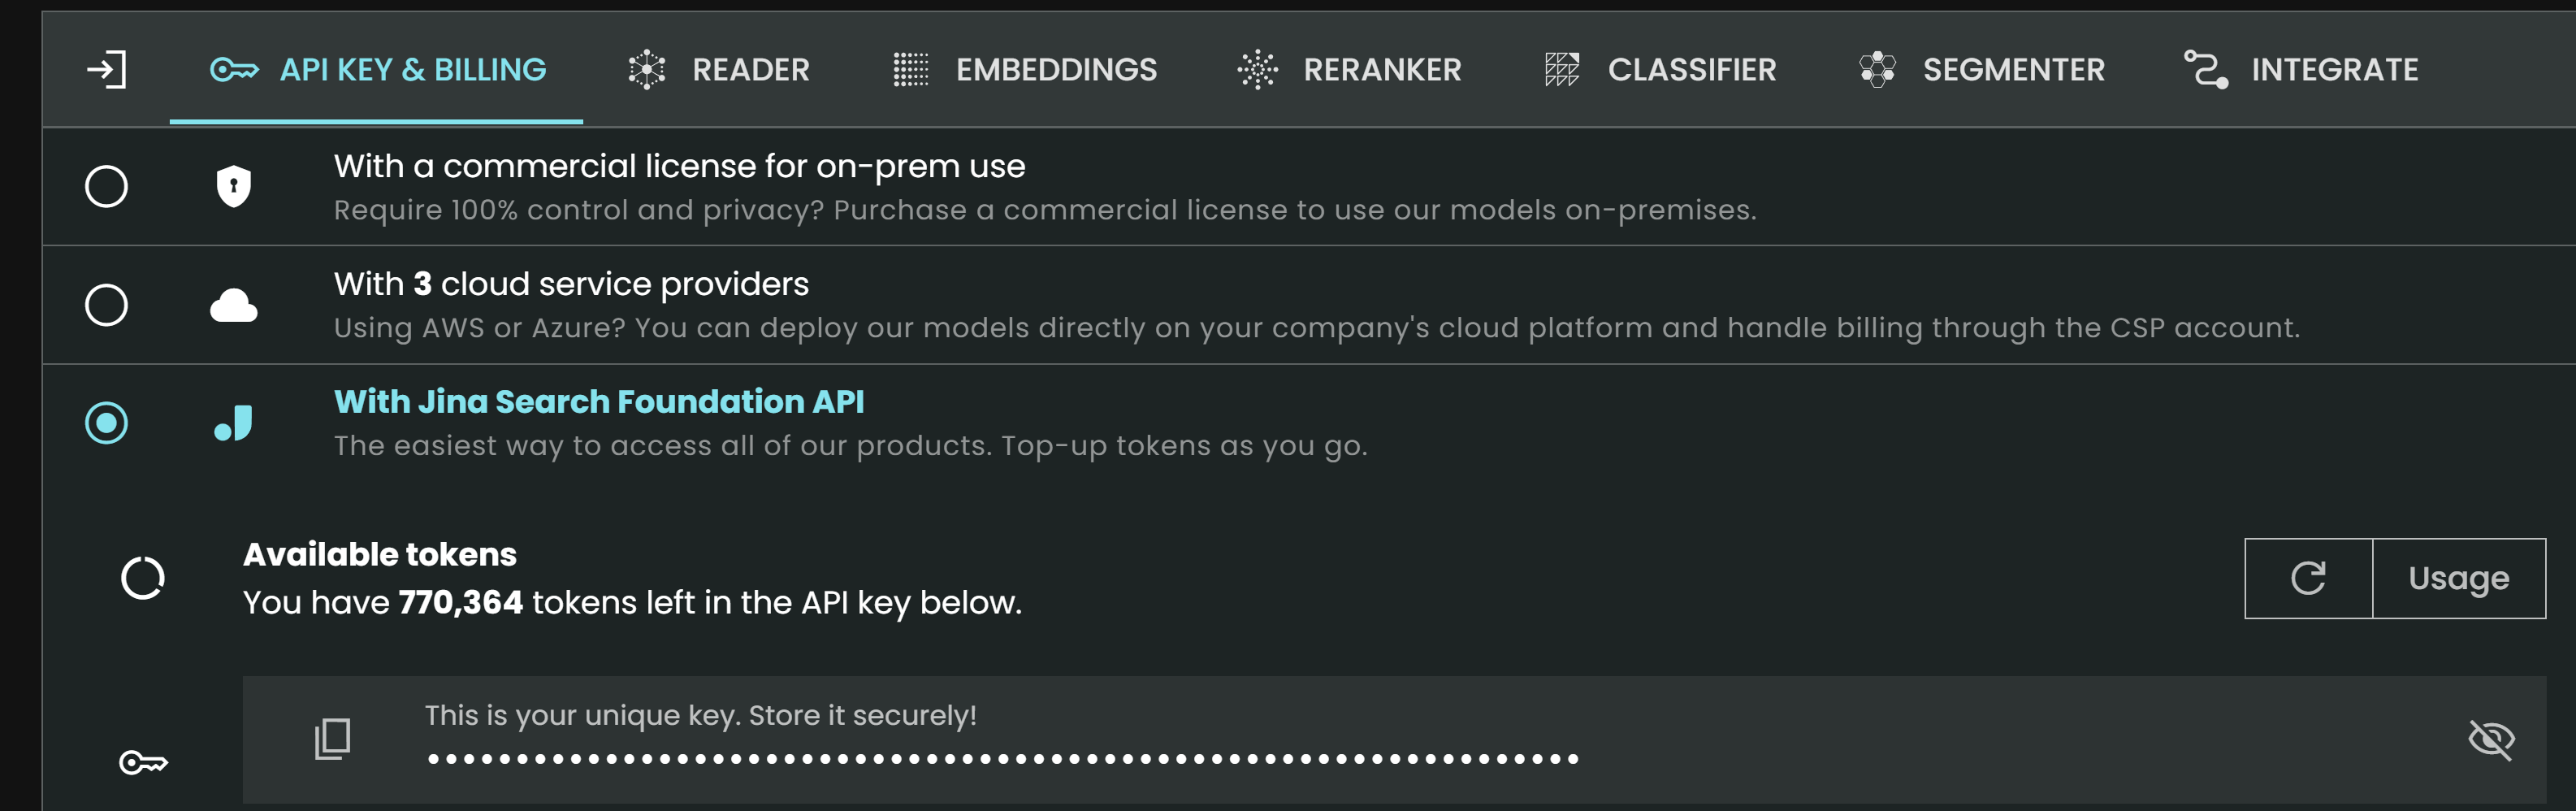

In [2]:
os.environ['JINA_API_KEY'] =''

In [ ]:
def urljoin(*args):
  """
  Joins given arguments into an url. Trailing but not leading slashes are
  stripped for each argument.
  """

  return "/".join(map(lambda x: str(x).rstrip('/'), args))


class MarkdownPipeline:

  def create_directory_from_url_with_slug(self, url):
    parsed_url = urlparse(url)
    path_segments = parsed_url.path.strip('/').split('/')
    directory_path = './docs/' + self.collection
    for segment in path_segments[:-1]:
      directory_path = os.path.join(directory_path, segment)
      os.makedirs(directory_path, exist_ok=True)
    filename = slugify(path_segments[-1])
    return os.path.join(directory_path, filename)

  def open_spider(self, spider):
    self.collection = spider.domain.title().replace('.', '')
    os.makedirs(f'./docs/{self.collection}', exist_ok=True)

  async def process_item(self, item, spider):
    response = await treq.get('https://r.jina.ai/' + item.get('url'),
                              headers={
                                  'Content-Type':
                                  'text/plain',
                                  "Authorization":
                                  f"Bearer {os.environ['JINA_API_KEY']}"
                              })

    content = await response.text()
    url = item.get('url')

    directory = self.create_directory_from_url_with_slug(url)

    with open(directory + '.md', 'w') as f:
      f.write(content)

    return item

  def close_spider(self, spider):
    self.client.close()


class PagingIncremental(CrawlSpider):
  name = "docs"
  custom_settings = {
      'DOWNLOAD_DELAY': '0',
      'FEED_EXPORT_ENCODING': 'utf-8',
      'DEPTH_LIMIT': '0',
      'AUTOTHROTTLE_ENABLED': 'True',
      'AUTOTHROTTLE_START_DELAY': '1',
      'AUTOTHROTTLE_MAX_DELAY': '3',
      "AUTOTHROTTLE_TARGET_CONCURRENCY": '1'
  }
  rules = (Rule(LinkExtractor(allow=r""), callback='parse', follow=True), )

  def __init__(self, url, *args, **kwargs):
    super().__init__(*args, **kwargs)
    # Visit all found sublinks
    print(url)
    self.domain = urlparse(url).hostname
    self.domain_name = self.domain.split('.')[1]
    self.allowed_domains = [self.domain]

    self.start_urls = [url]

  def parse(self, response):

    item = {}
    item["url"] = response.url
    time.sleep(.1)
    yield item


def process_docs(url):
  process = CrawlerProcess({
      'USER_AGENT': 'Mozilla/5.0',
      'ITEM_PIPELINES': {
          '__main__.MarkdownPipeline': 1,
      },
  })

  process.crawl(PagingIncremental, url=url)
  process.start(stop_after_crawl=True)


if __name__ == "__main__":
  process_docs(DOCS_URL)


If in jupyter:

In [ ]:
process_docs(DOCS_URL)